In [13]:
import cdsapi
from atlite.gis import shape_availability, ExclusionContainer
from rasterio.plot import show
import numpy as np

import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

In [14]:
# Enable log info to show during the process
import warnings
import logging

# warnings.simplefilter("default", DeprecationWarning)
logging.captureWarnings(True)
logging.basicConfig(level=logging.INFO)

# Historical comparison with data from Atlite

In [15]:
from countrygroups import EUROPEAN_UNION

# Adding non-EU countries to the list of countries
others = (["Switzerland","Czech Republic", "Ukraine","Moldova", "Serbia","Albania", "United Kingdom", 
           "Montenegro","Bosnia and Herzegovina","North Macedonia","Kosovo"])
europe_list = EUROPEAN_UNION.names + others
europe_list.remove("Czechia")

In [16]:
# Defining shape of European countries

shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shpreader.Reader(shpfilename)
Europe = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
#).reindex(["Austria","Denmark","Germany","Italy"])
).reindex(europe_list)

  in_crs_string = _prepare_from_proj_string(in_crs_string)



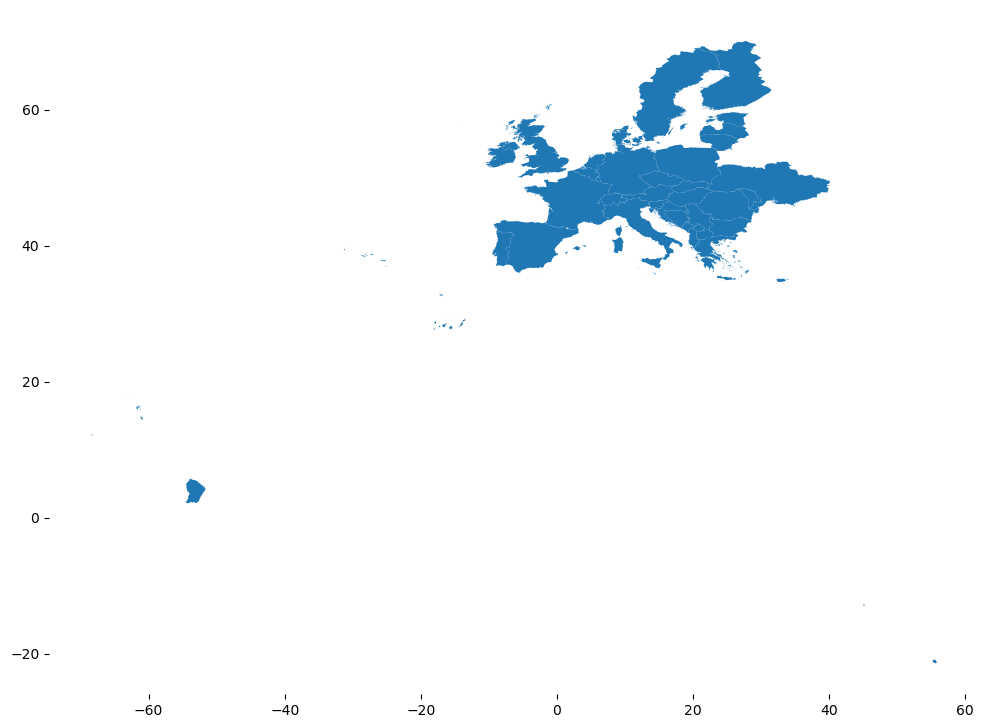

In [17]:
Europe.plot(figsize=(12,12),aspect='equal').set_frame_on(False)

In [18]:
# Removing extra territories (islands in the Atlantic, etc.)
mask = (-11, 30, 50, 70)
Europe = Europe.clip(mask)

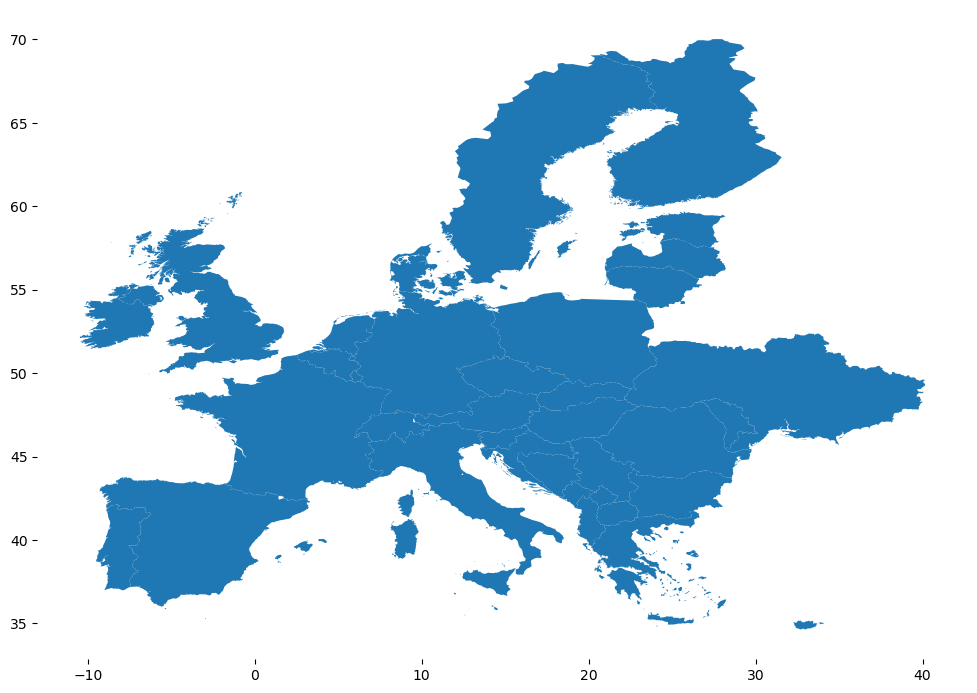

In [19]:
Europe.plot(figsize=(12,12),aspect='equal').set_frame_on(False)

In [20]:
bounds = Europe.cascaded_union.buffer(1).bounds
cutout2 = atlite.Cutout(
    "Europe", module="era5", bounds=bounds, time=slice("2013-01-01", "2013-01-02")
)

  bounds = Europe.cascaded_union.buffer(1).bounds



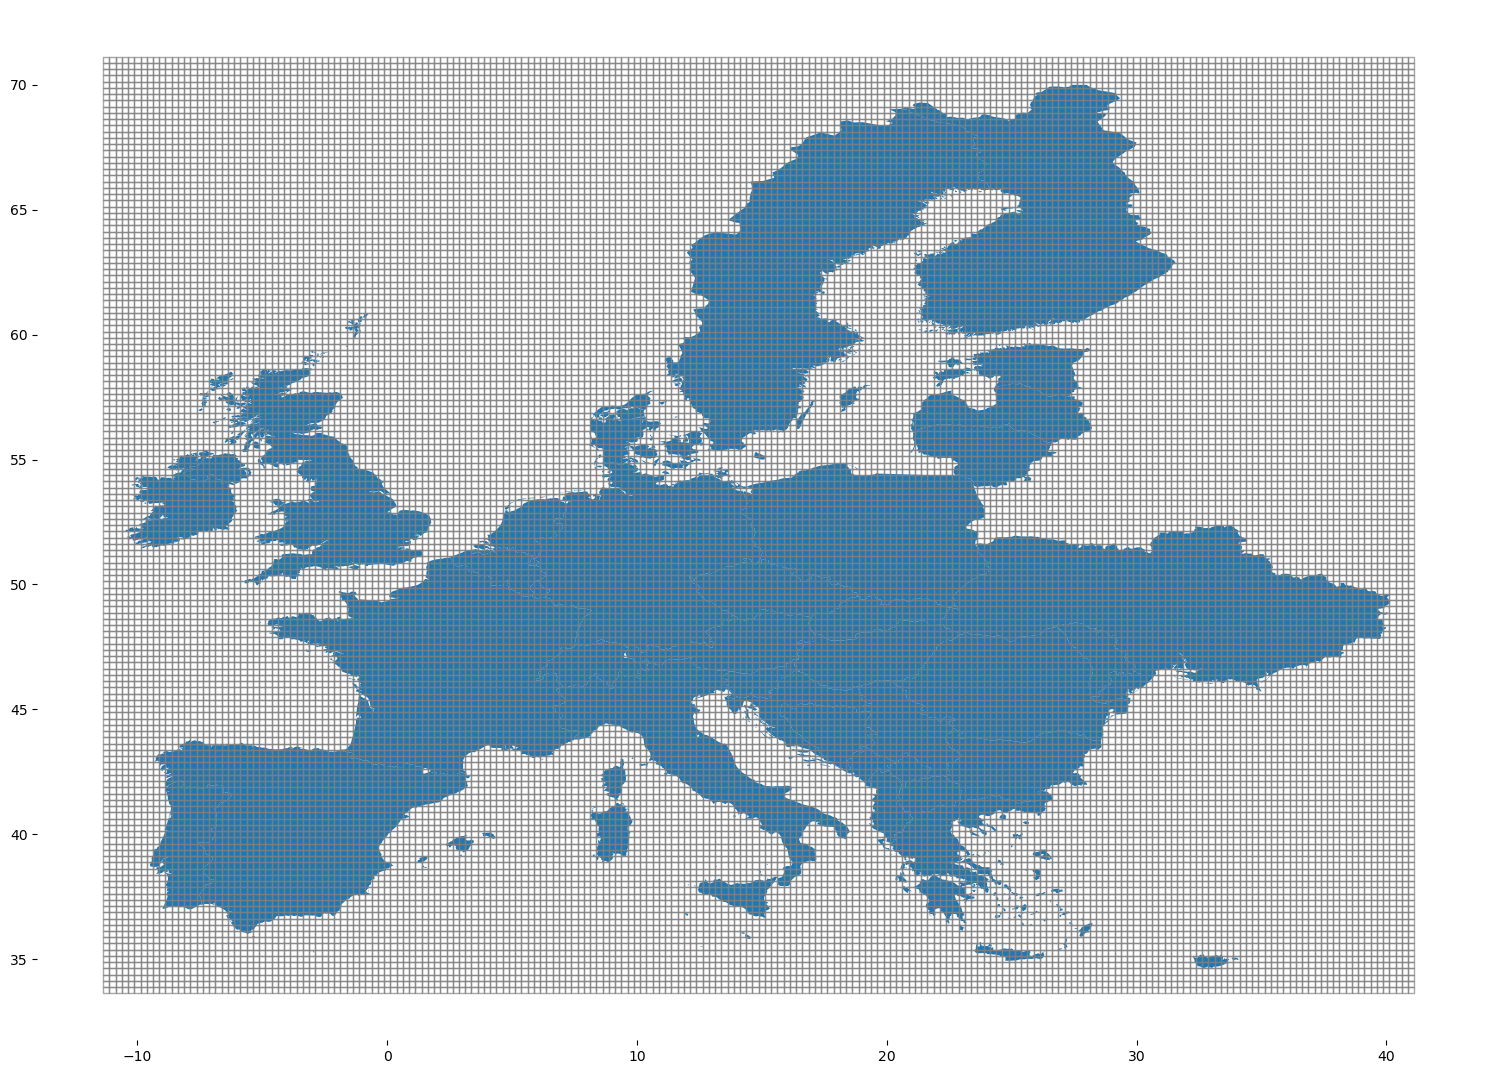

In [21]:
fig, ax = plt.subplots(figsize=(15, 15))
Europe.plot(ax=ax,aspect="equal",zorder=1).set_frame_on(False)
cutout2.grid.plot(ax=ax, edgecolor="grey", color="None",aspect="equal",alpha=0.7,zorder=4)
fig.tight_layout()

In [22]:
CORINE = "corine.tif"
excluder = ExclusionContainer()
excluder.add_raster(CORINE, codes=range(20))

In [23]:
Europe_useful = Europe.geometry.to_crs(excluder.crs)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
Europe_useful.plot(ax=ax, edgecolor="k", color="None",aspect="equal").set_frame_on(False)
count = 0
eligible_share = np.zeros(len(europe_list))

for i in europe_list:
    country = Europe_useful.loc[[i]].geometry.to_crs(excluder.crs)
    masked, transform = shape_availability(country, excluder)
    eligible_share[count] = masked.sum() * excluder.res**2 / Europe_useful.loc[[i]].geometry.item().area
    ax = show(masked, transform=transform, adjust=True, cmap="Greens", ax=ax)
    count = count + 1
Europe_useful.plot(ax=ax, edgecolor="k", color="None",aspect="equal").set_frame_on(False)

In [ ]:
# masked, transform = shape_availability(Europe_useful, excluder)
# eligible_share = masked.sum() * excluder.res**2 / Europe_useful.geometry.item().area
# eligible_share

In [ ]:
y_pos = np.arange(len(europe_list))

f, ax = plt.subplots(figsize=(10,10))
ax.set_yticks(y_pos, labels=europe_list)
ax.barh(y_pos, eligible_share,align='center')
ax.invert_yaxis()
ax.set_xlabel('Available land ratio')
ax.set_title('Ratio of land available for energy production')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ax = show(masked, transform=transform, cmap="Greens", ax=ax)
Europe_useful.plot(ax=ax, edgecolor="k", color="None",aspect="equal").set_frame_on(False)

In [ ]:
transform